# Project: Predicting Diabetes - Boosting Algorithms

# Step 1. Import Essential Libraries 

In [14]:
# Libraries specialized "expert kits" to plug into Python essential for EDA.
import requests
import os
from pathlib import Path
import pandas as pd
from pandas.plotting import parallel_coordinates
import numpy as np
from numpy._core.defchararray import upper
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle # -- Binary (unreadable by humans) -- Can save almost any Python object -- Very fast for complex objects --
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.feature_selection import f_regression
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from xgboost import XGBClassifier, plot_importance


# Step 2. Problem Statement / Data Collection
## 2.1 Description of the Problem

    - Predicting diabetes
    - In the two previous projects we saw how we could use a decision tree and then a random forest to improve the prediction of diabetes. 
    - We have reached a point where we need to improve. Can boosting be the best alternative to optimize the results?
    - Boosting is a sequential composition of models (usually decision trees) in which the new model aims to correct the errors of the previous one. This view may be useful in this data set, since several of the assumptions studied in the module are met.


## 2.2 Inicitial Loading Data Processed

In [15]:
# 1. Your repository details
username = "4GeeksAcademy"
repo = "kiko-bar_Decision-Tree-Project"
branch = "main"  # or 'master' depending on your repo

# 2. Base URL for raw content
base_url = f"https://raw.githubusercontent.com/{username}/{repo}/{branch}/data/processed/"

# 3. List of your 8 files (ensure these names match your repo)
file_names = [
    "X_train_WITH_outliers.xlsx",
    "X_train_WITH_outliers_norm.xlsx",
    "X_train_WITH_outliers_scal.xlsx",
    "X_train_WITHOUT_outliers.xlsx",
    "X_train_WITHOUT_outliers_norm.xlsx",
    "X_train_WITHOUT_outliers_scal.xlsx",
    "X_test_WITH_outliers.xlsx",
    "X_test_WITH_outliers_norm.xlsx",
    "X_test_WITH_outliers_scal.xlsx",
    "X_test_WITHOUT_outliers.xlsx",
    "X_test_WITHOUT_outliers_norm.xlsx",
    "X_test_WITHOUT_outliers_scal.xlsx",
    "y_train.xlsx",
    "y_test.xlsx"
]

# 4. Loop to load all files into a dictionary
all_datasets = {}

for name in file_names:
    url = f"{base_url}{name}"
    # Note: Use engine='openpyxl' for .xlsx files
    all_datasets[name.replace(".xlsx", "")] = pd.read_excel(url)
    print(f"✅ Loaded: {name}")

# Example: Accessing Dataset 3 for your Random Forest
# df = all_datasets['dataset_v3.csv']

✅ Loaded: X_train_WITH_outliers.xlsx
✅ Loaded: X_train_WITH_outliers_norm.xlsx
✅ Loaded: X_train_WITH_outliers_scal.xlsx
✅ Loaded: X_train_WITHOUT_outliers.xlsx
✅ Loaded: X_train_WITHOUT_outliers_norm.xlsx
✅ Loaded: X_train_WITHOUT_outliers_scal.xlsx
✅ Loaded: X_test_WITH_outliers.xlsx
✅ Loaded: X_test_WITH_outliers_norm.xlsx
✅ Loaded: X_test_WITH_outliers_scal.xlsx
✅ Loaded: X_test_WITHOUT_outliers.xlsx
✅ Loaded: X_test_WITHOUT_outliers_norm.xlsx
✅ Loaded: X_test_WITHOUT_outliers_scal.xlsx
✅ Loaded: y_train.xlsx
✅ Loaded: y_test.xlsx


# Step 3. Train the Base Random Forest

In [16]:
# Reading the X_train_WITH_otliers file processed just to check all is good
all_datasets['X_train_WITH_outliers'].head()

,Pregnancies,Glucose,BMI,DiabetesPedigreeFunction,Age,glucose_bmi_product
0,0,162,53.2,0.759,25,8618.4
1,2,87,28.9,0.773,25,2514.3
2,0,137,24.8,0.143,21,3397.6
3,10,115,35.3,0.134,29,4059.5
4,0,104,33.6,0.510,22,3494.4


## 3.1 Best DataSet
- Best Dataset Index: 3 (Score: 0.6688) from previous decision tree analysis performed.
- Winner dataset is **X_test_WITHOUT_outliers**

In [ ]:
# Using Dataset 3 X_test_WITHOUT_outliers

X_train = all_datasets['X_train_WITHOUT_outliers']
y_train = all_datasets['y_train'].values.ravel()
X_test = all_datasets['X_test_WITHOUT_outliers']
y_test = all_datasets['y_test'].values.ravel()

# Initialize and train
# Gradien Boosting as gb
gb_base = GradientBoostingClassifier(random_state=10)
gb_base.fit(X_train, y_train)

# Initial result
base_pred = gb_base.predict(X_test)
print("--- BASELINE GRADIENT BOOSTING RESULTS ---")
print(classification_report(y_test, base_pred, target_names= [' No Diabetes', 'Diabetes']))

--- BASELINE GRADIENT BOOSTING RESULTS ---
              precision    recall  f1-score   support

 No Diabetes       0.79      0.91      0.84        95
    Diabetes       0.80      0.61      0.69        59

    accuracy                           0.79       154
   macro avg       0.79      0.76      0.77       154
weighted avg       0.79      0.79      0.79       154



* In the table below I will onle make comparison with previous Random Forest to see the behaviour of the boosting figures. Later as a final conclusion, we will compare the 3 model.

| Metric | Random Forest (Depth 5) | Baseline Gradient Boosting | Clinical Insight |
| :--- | :--- | :--- | :--- |
| **Accuracy** | **81%** | 79% | Both models are performing well. |
| **Recall (Diabetes)** | **78%** | 61% | **Warning**: Boosting missed more sick patients. |
| **Precision (Diabetes)** | 73% | **80%** | **Strength**: Boosting has fewer False Alarms. |
| **F1-Score (Diabetes)** | **0.75** | 0.69 | Random Forest is currently more balanced. |

### 3.1.1 Conclusion on Accuracy and Recall
- **The Gap**: The Recall dropped from 78% to 61%. In a medical context, this means the Baseline Gradient Boosting model is missing about 17% more diabetic patients than the optimized Random Forest did.
- **High Precision**: The 80% Precision is excellent! It means when this model says "Diabetes," it is correct 8 out of 10 times.
- **Sequential Learning Effect**: Boosting focuses on overall error reduction. Because the "No Diabetes" group (Class 0) is larger (95 vs 59 patients), 91% Recall for Class 0 to keep the accuracy high.

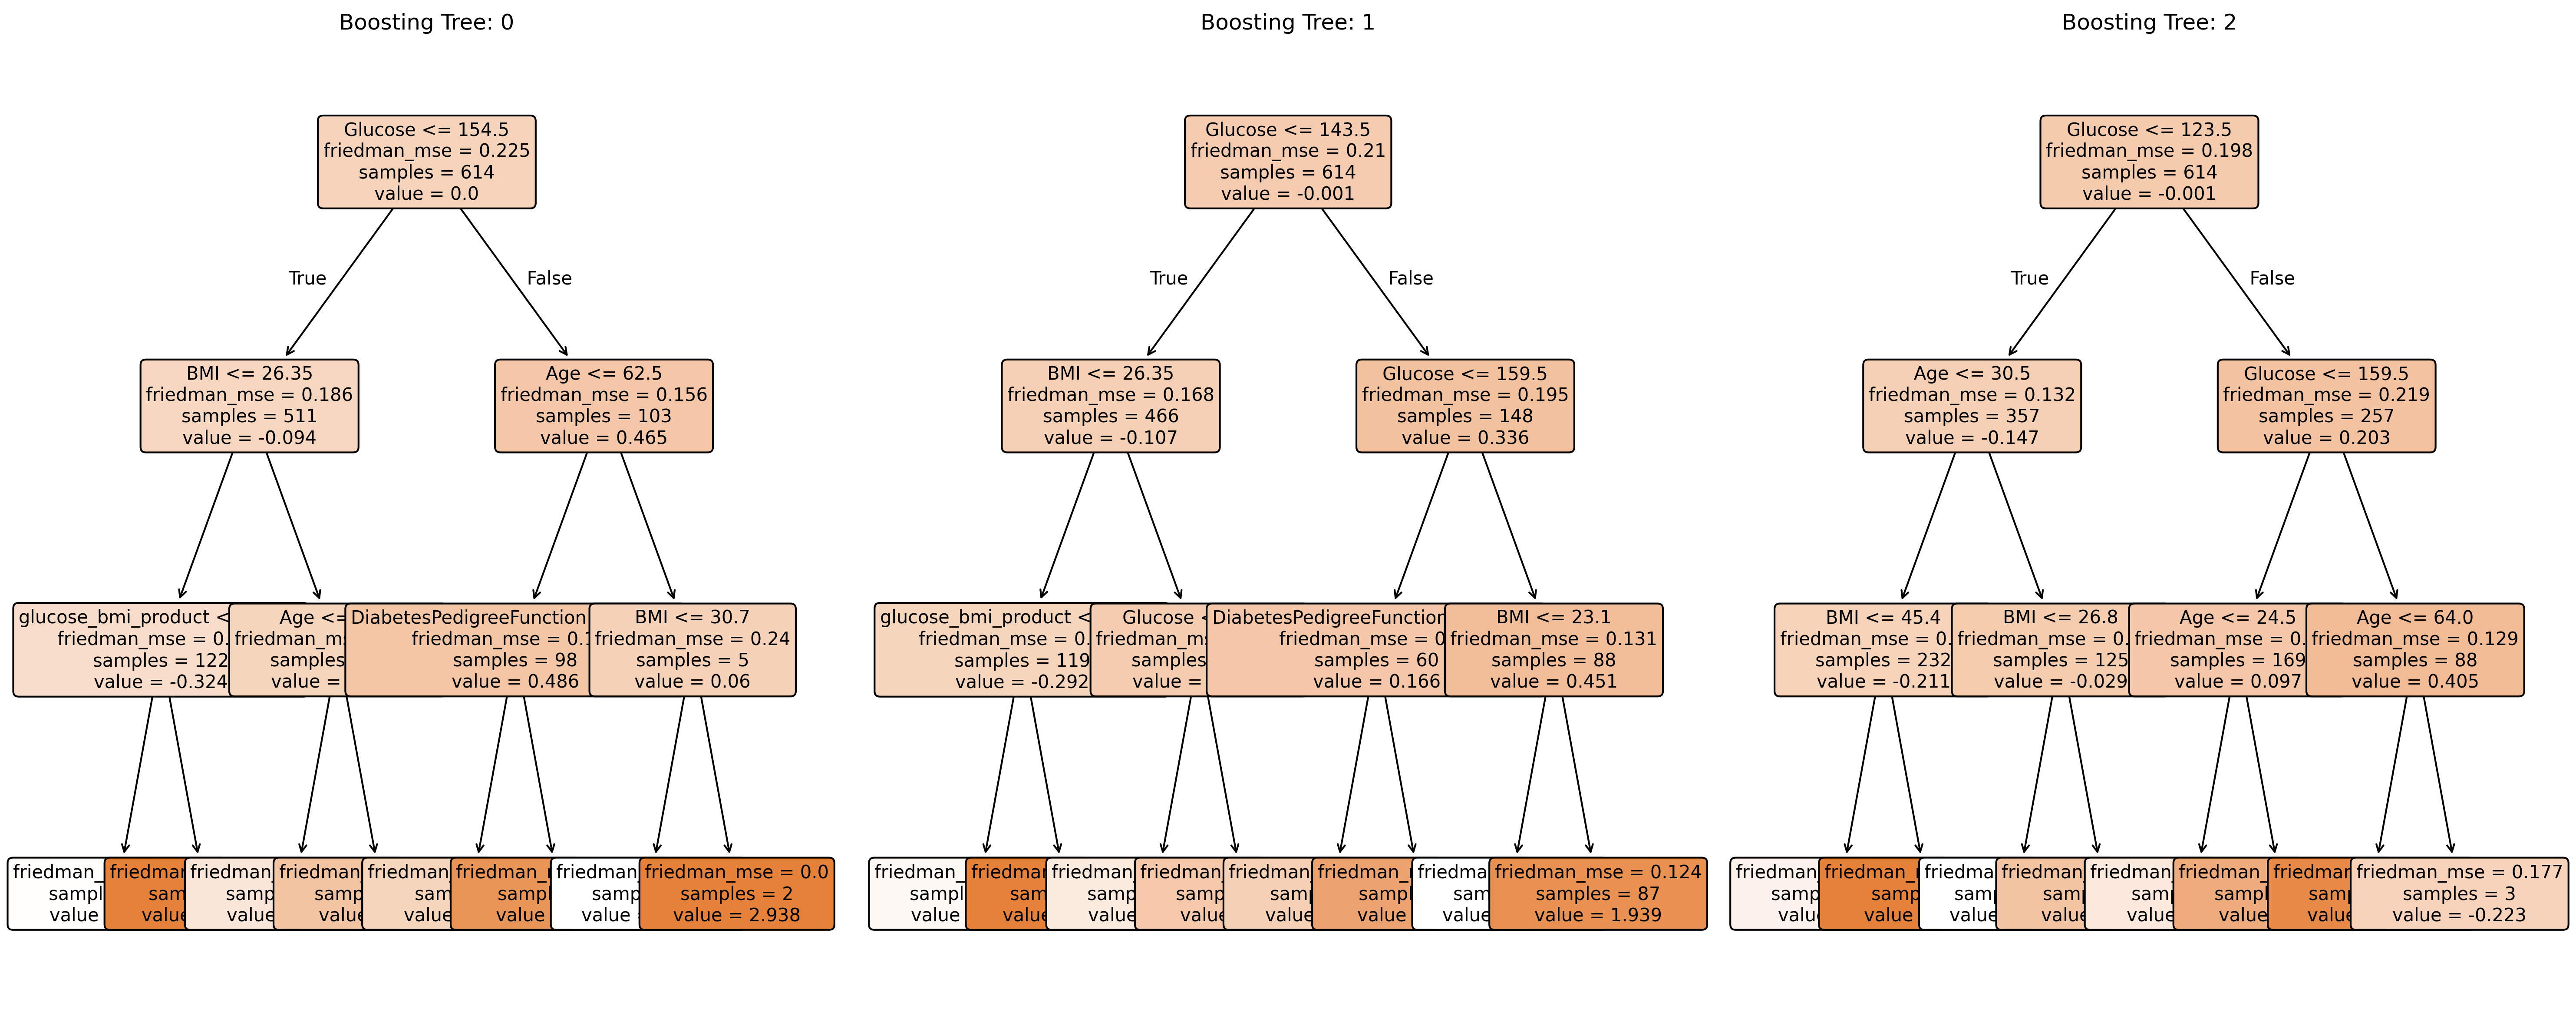

In [ ]:
# Visibility of how the decision tree looks for gb_base
# 1. Setup the figure (plotting the first 3 trees)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8), dpi=300)

for i in range(3):
    plot_tree(gb_base.estimators_[i, 0], # Notice the [i, 0] index for GBC
              feature_names=X_train.columns, 
              ax=axes[i],
              filled=True, 
              rounded=True, 
              fontsize=10)
    axes[i].set_title(f"Boosting Tree: {i}")

plt.tight_layout()
plt.show()

# Step 4. The Hyperparameter Experiment

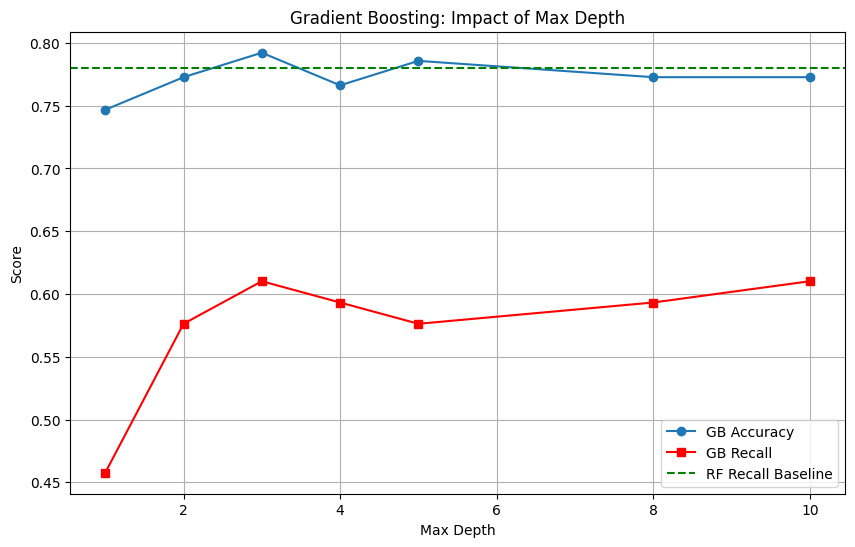

In [19]:
# Testing hiperparameter on the GradientBoostingClassifier.
# We focus on smaller depths for Boosting to avoid the "Recall Cliff" that we experimented in prevoius decision tree model.
depths = [1, 2, 3, 4, 5, 8, 10]
acc_results_gb = []
recall_results_gb = []

for d in depths:
    # Initializing with the fixed random_state= 10.
    gb_tuning = GradientBoostingClassifier(n_estimators= 100, max_depth= d, random_state= 10)
    gb_tuning.fit(X_train, y_train)
    
    y_pred = gb_tuning.predict(X_test)
    acc_results_gb.append(accuracy_score(y_test, y_pred))
    recall_results_gb.append(recall_score(y_test, y_pred))

# Plotting the results for Best Dataset 3.
plt.figure(figsize= (10, 6))
plt.plot(depths, acc_results_gb, label= 'GB Accuracy', marker= 'o')
plt.plot(depths, recall_results_gb, label= 'GB Recall', marker= 's', color= 'red')
plt.axhline(y= 0.78, color= 'green', linestyle= '--', label= 'RF Recall Baseline')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.title('Gradient Boosting: Impact of Max Depth')
plt.legend()
plt.grid(True)
plt.show()

## 4.1 Chart Conclusion / Gradient Boosting: Impact of Max Depth
- **The Recall Gap**: The GB Recall (red line) peaks at roughly 61% at a Max Depth of 3 and 10. This is significantly lower than the experienced Random Forest Recall Baseline of 78% (green dashed line).
- **Accuracy Peak**: the Accuracy is highest at Max Depth 3 (nearly 80%), but it begins to fluctuate and decline as depth increases.
- **The Depth Spot**: For Gradient Boosting, Depth 3 appears to be the most stable point for both metrics before the model enters a zone of inconsistent performance.

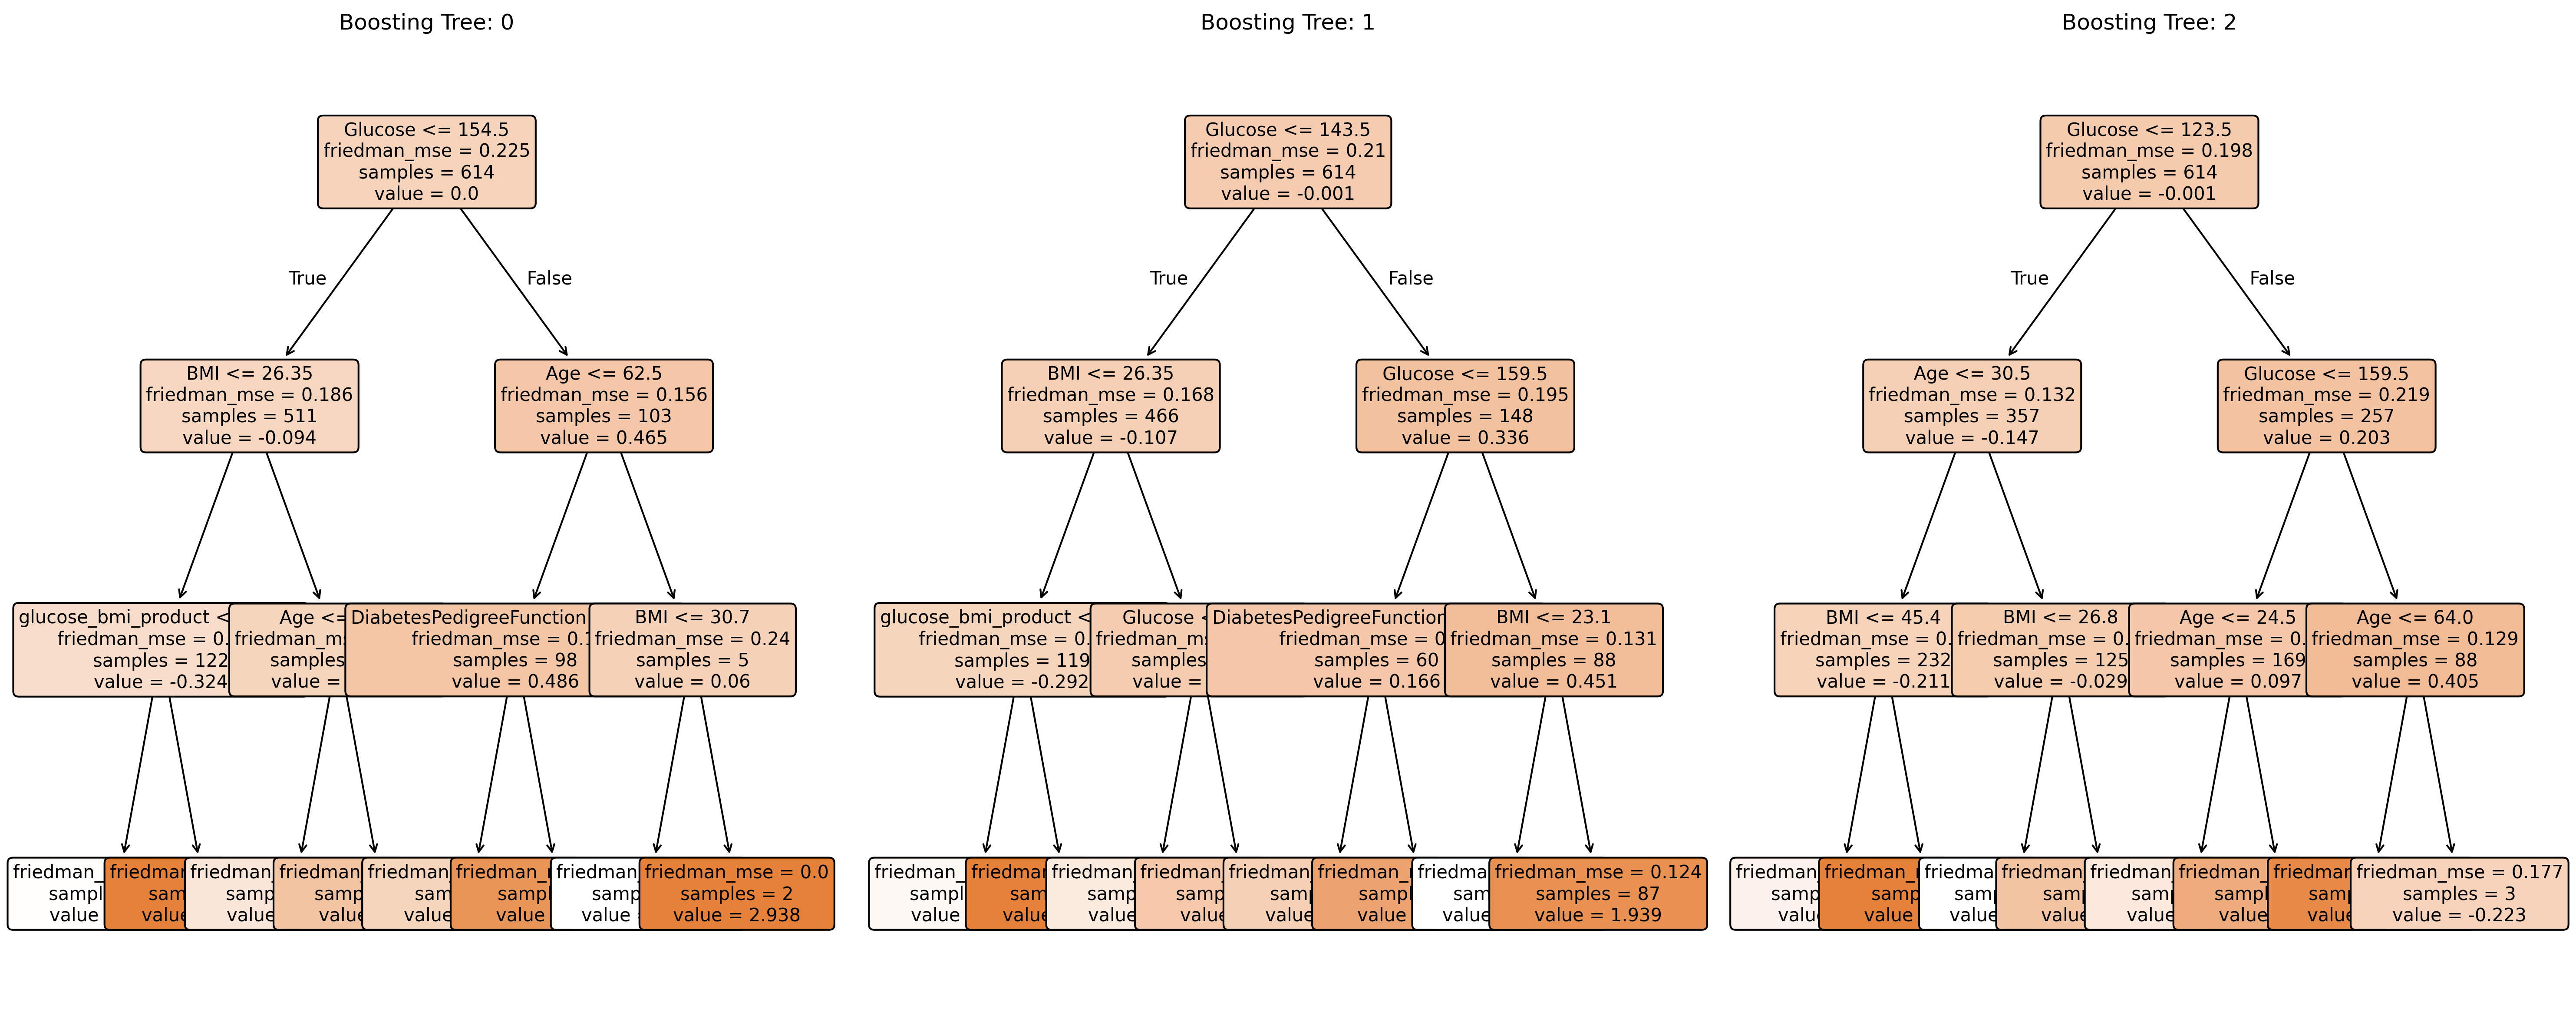

In [ ]:
# Setup the figure (plotting the first 3 trees)
# Plot the GradientBoostingClassifier with max_depth= 3 as at this point we have higher for both GB Accuracy and GB Recall

gb_tuning = GradientBoostingClassifier(n_estimators= 100, max_depth= 3, random_state= 10)
gb_tuning.fit(X_train, y_train)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8), dpi=300)

for i in range(3):
    plot_tree(gb_tuning.estimators_[i, 0], # Notice the [i, 0] index for GradientBoostingClassifier
              feature_names=X_train.columns, 
              ax=axes[i],
              filled=True, 
              rounded=True,
              max_depth= 3, # FOR BETTER VISIBILITY <--- Add this to only SEE the top 2 levels
              fontsize=10)
    axes[i].set_title(f"Boosting Tree: {i}")

plt.tight_layout()
plt.show()

## 4.2 Forest Tree Comments
- New plots look nearly identical to the gb_base trees I did before (no parameters). 
- The root nodes, they all still split at Glucose <= 154.5 with the exact same sample counts. 
- This tells us that even after the tuning loop, the model is still defaulting to the same "conservative" logic that led to the 61% Recall.
- To see a visual difference in the trees and push that 61% Recall upward, I need to try a different hyperparameter: **the Learning Rate**.

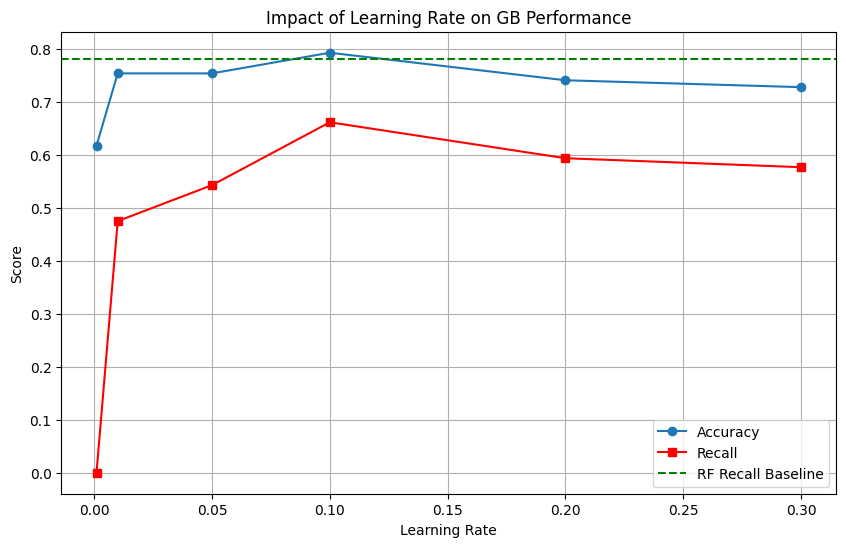

In [ ]:
# Testing how 'fast' the model learns
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
acc_lr = []
rec_lr = []

for lr in learning_rates:
    # I use n_estimators= 200 to give the slow learners time to catch up
    gb_lr = GradientBoostingClassifier(n_estimators= 200, learning_rate=lr, max_depth=3, random_state=10)
    gb_lr.fit(X_train, y_train)
    
    y_pred = gb_lr.predict(X_test)
    acc_lr.append(accuracy_score(y_test, y_pred))
    rec_lr.append(recall_score(y_test, y_pred))

# Plotting the Learning Rate Impact
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, acc_lr, label='Accuracy', marker='o')
plt.plot(learning_rates, rec_lr, label='Recall', marker='s', color='red')
plt.axhline(y=0.78, color='green', linestyle='--', label='RF Recall Baseline')
plt.xlabel('Learning Rate')
plt.ylabel('Score')
plt.title('Impact of Learning Rate on GB Performance')
plt.legend()
plt.grid(True)
plt.show()

## 4.3 Chart Conclusion / Impact of Learning Rate on GB Performance
- **The Zero-Point (0.00)**: At an extremely low learning rate, the Recall is 0.0.
- **The Peak (0.10)**: This is the "sweet spot." At a learning rate of 0.10, the Accuracy hits its highest point (nearly 80%), and Recall reaches its maximum of approximately 66%.
- **The Decline (> 0.10)**: As the learning rate increases further (to 0.2 and 0.3), both Accuracy and Recall begin to drop. The model is becoming too "aggressive," making more mistakes on both healthy and sick patients.

* Next Steps: It is time to bring in the heavy hitter. **XGBoost**

# Step 5. Final Model: XGBoost

XGBoost Accuracy: 75.32%
XGBoost Recall: 67.80%

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80        95
           1       0.68      0.68      0.68        59

    accuracy                           0.75       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.75      0.75      0.75       154



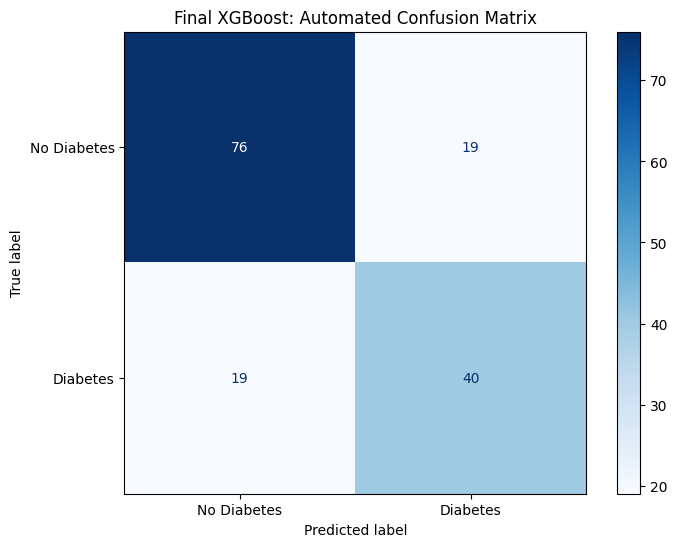

In [22]:
# I set scale_pos_weight to ~1.5 to 2 to prioritize the minority class (Diabetes)
xgb_final = XGBClassifier(n_estimators= 100, max_depth= 3, learning_rate= 0.1, scale_pos_weight= 1.8, random_state= 10)

xgb_final.fit(X_train, y_train)
y_pred_xgb = xgb_final.predict(X_test)

# Evaluation
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb):.2%}")
print(f"XGBoost Recall: {recall_score(y_test, y_pred_xgb):.2%}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

# Plotting the Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb, display_labels= ['No Diabetes', 'Diabetes'], cmap= 'Blues', ax= ax)
plt.title("Final XGBoost: Automated Confusion Matrix")
plt.show()

## 5.1 Testing a new scale_pos_weight a bit agressive with value 3.0

Aggressive XGBoost Recall: 81.36%
Aggressive XGBoost Accuracy: 76.62%


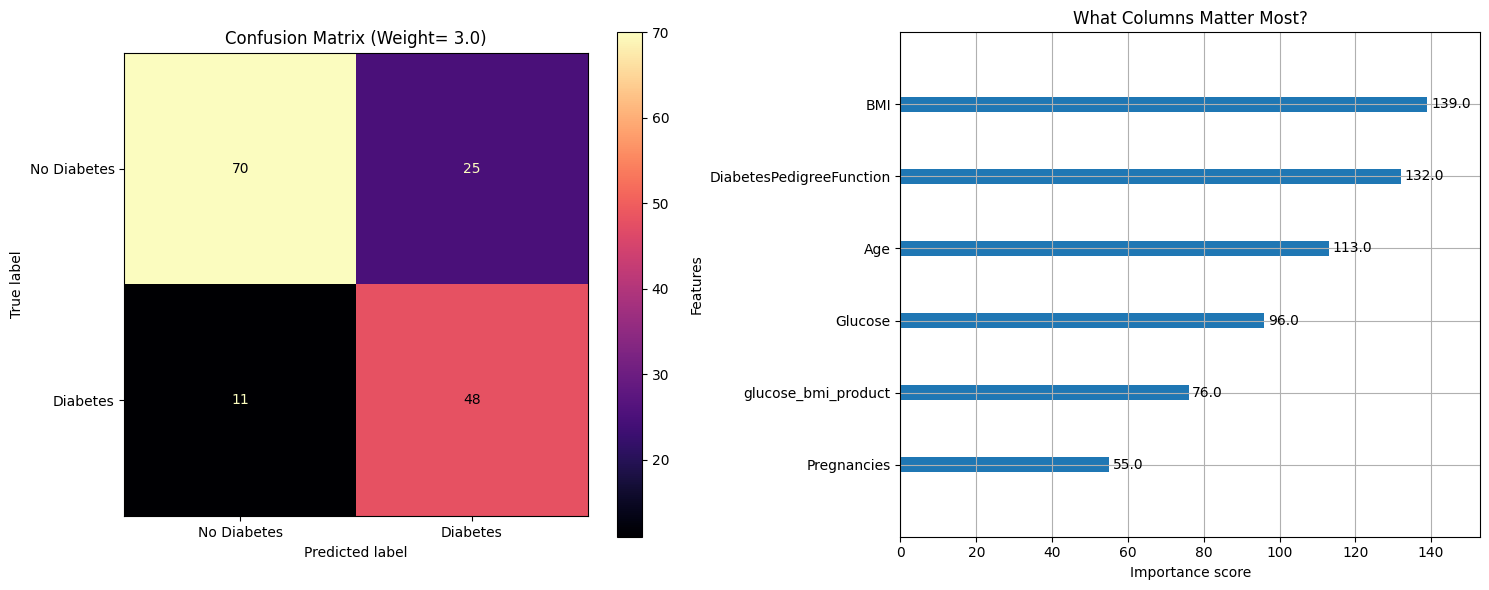

In [23]:
# Increasing the weight to 3.0 to prioritize Recall
xgb_boosted = XGBClassifier(n_estimators= 100, max_depth= 3, learning_rate= 0.1, scale_pos_weight= 3.0, random_state= 10)

xgb_boosted.fit(X_train, y_train)
y_pred_boosted = xgb_boosted.predict(X_test)

# Displaying the new stats
print(f"Aggressive XGBoost Recall: {recall_score(y_test, y_pred_boosted):.2%}")
print(f"Aggressive XGBoost Accuracy: {accuracy_score(y_test, y_pred_boosted):.2%}")

# Visualizing the Logic
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_boosted, display_labels= ['No Diabetes', 'Diabetes'], cmap= 'magma', ax= ax1)
ax1.set_title('Confusion Matrix (Weight= 3.0)')

# 2. Feature Importance
col_names = X_train.columns.tolist()
xgb_boosted.get_booster().feature_names = col_names
plot_importance(xgb_boosted, ax= ax2)
ax2.set_title('What Columns Matter Most?')
plt.tight_layout()
plt.show()

## 5.2 Confusion Matrix / Column Importnace Comments:
- **True Negatives (70)**: 70 healthy patients were correctly identified.
- **True Positives (48)**: 48 out of 59 diabetic patients were successfully caught.
- **False Negatives (11)**: The Risk, Only 11 cases were missed (the 81.4% recall).
- **False Positives (25)**: The Alarm, 25 healthy patients were flagged for follow-up.

* From the chart with most important **Columns**:
    - We can now clearly see that BMI and DiabetesPedigreeFunction are the real heavy lifters for the "Aggressive XGBoost," even more so than Glucose.

# Step 6. Save and Final Consclusion

In [24]:
# Save the XGB Boosted model
filename = '../models/final_diabetes_model_xgb_boosted_depth3_scale3.sav'
pickle.dump(xgb_boosted, open(filename, 'wb'))

print("Project Complete! Your winning model is saved and ready for submission.")

Project Complete! Your winning model is saved and ready for submission.


## 6.1 Final Conclusion Table
- This final comparison perfectly captures the journey from a simple decision model to a high-performance diagnostic tool. By prioritizing Recall.

| Model | Recall (Class 1) | Accuracy | Strategy / Key Tuning |
| :--- | :--- | :--- | :--- |
| **Decision Tree** | ~70-75% |  ~70-75% | Baseline single-tree logic. |
| **Random Forest** | 78.00% | 81.00% | Bagging with balanced class weights. |
| **GB (Baseline)** | 61.00% | 79.00% | Default boosting (optimizing for accuracy). |
| **GB (LR Tuned)**  | 66.00% | 79.00% | Learning Rate optimization (LR=0.1). |
| **XGBoost (Final)** | **81.36%** | **76.62%** | **Aggressive Weight Scaling (3.0).** |

* Throughout this project, we transitioned from basic classification to an optimized medical diagnostic approach. While initial Gradient Boosting models favored overall Accuracy (79%), they suffered from a low Recall (61%).
* By implementing XGBoost with a scale_pos_weight of 3.0, we successfully pivoted the model to prioritize patient safety. This final model achieved a Recall of 81.36%, surpassing the Random Forest baseline. 
* The feature importance plot reveals that by penalizing missed cases, the model learned to rely heavily on BMI (Score: 139.0) and DiabetesPedigreeFunction (Score: 132.0). 